# Code and visual trace analyses
### Supplementary material - Anonymous submission #18 to CHES 2021

The goal of this notebook is to present the dataset and to provide a first code analysis of the public implementation in assembly, coupled with a visual inspection of the traces. The idea is to emphasize how a potential adversary could jointly exploit this information in order to localize some *Points of Interest* (PoIs) useful for an attack, even without the knowledge of a *Signal-to-Noise* (SNR) computation that would require the knowledge of the mask values during the profiling phase.

Our analysis will rely on the assembly code available [on the SecAES STM32 Github](https://github.com/ANSSI-FR/SecAESSTM32/blob/master/src/aes/affine_aes.S).

In [ ]:
%pip install brewer2mpl

In [ ]:
import sys
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import brewer2mpl

%matplotlib inline


# Import from the raw data
file_name = "/content/snapshot.npy"
traces = np.load(file_name)

To make the visual analysis of the traces easier to compare with the code analysis, we propose to load a batch of $10$ traces, and to visualize its average. This would make a better discrepancy between the different operations to recognize.

In [ ]:
class RunningMean():
    """
    A simple class that maintains the running mean of a random
    variable.
    """
    def __init__(self):
        self.m = 0
        self.n = 0
    
    def update(self, x_n):
        """
        Updates the running mean with a new observation x_n of the random
        variable X.
        """
        x_n = np.array(x_n, dtype=np.float)
        self.m = (self.n * self.m + x_n) / (self.n + 1)
        self.n += 1
    
    def __call__(self):
        return self.m


trace_mean_ = RunningMean()    # Useful to compute the average on-the-fly without yielding numerical issues.
for i, trace in enumerate(traces):
    sys.stdout.write("\rAdding trace {} to the average.\t".format(i))
    trace_mean_.update(trace)
trace_mean = trace_mean_()
del traces

Adding trace 9 to the average.	

## 1. Code analysis of the pre-processing part

The target implementation is an AES directly written in assembly with the ARM [ISA](http://infocenter.arm.com/help/index.jsp?topic=/com.arm.doc.ddi0337h/CHDDIGAC.html&_ga=2.185406826.231832108.1586949621-1015747362.1586772426). It is protected with two counter-measures:
* [*Affine masking*](https://ia.cr/2010/523): any computation involving a sensitive variable is replaced by the processing of three other variables: $r_m, \beta, r_m \cdot Z + \beta$.
* *Random shuffling*: the order of the bytes in the AES state and in the key state is randomly shuffled.

To implement those protections, the encryption is split into 3 main functions:
* `aes_loadKey` (l. 1271): securely imports the secret key, protected with affine masking and random shuffling.
* `aes_init_enc` (l. 1374): imports the masks used to protect the AES state according to the affine scheme, prepares the pre-computation tables.
* `aes_enc` (l. 1535): imports the plaintext, protects it with the counter-measures, and runs the AES rounds before removing the masks and applying the inverse permutation at the end to return the ciphertext.

We know from the implementation of the affine masking that to be able to succeed a recovery of the i-th key byte, an adversary must target one or several window(s) of the traces containing at least the following leakages:
1. The multiplicative mask $r_m$
2. One additive mask  $\beta \in \{r_{in}, r_{out}, M[perm[i]]\}$
3. The masked variable $r_m \cdot Z[perm[i]] + \beta$, where $Z = f(P, K)$
4. (Optional) The permutation indice $perm[i]$

We distinguish two types of useful variables:
* Those with fixed value along the execution of AES. They can be extracted from any round or even from the pre-processing: `permIndices`, `permIndicesbis`, `r_m`, `r_in`, `r_out`.
* Those whose value evolves through the execution of the primitive: `stateM`, `maskedState`. They can only be recovered from the very first round.
The latter type of variable being less likely to boradly leak in the traces, we choose to ignore it in our attacks. Hence, the goal of our code analysis is to detect the most relevant zones where the leakages of 
$$r_m, r_{in}, r_{out}, r_m \cdot Z[perm[i]] + r_{in}, r_m \cdot Z[perm[i]] + r_{out}, perm[i]$$
could occur.
We propose hereafter a brief code analysis of the pre-processing part.

### Targeting the AES rounds is not sufficient
For an attacker without any knowledge of the values of the random masks during the profiling phase, this step is necessary, as **the multiplicative mask $r_m$ alone cannot leak during the AES rounds**. Indeed, since it is common to every byte of the AES state, we have for all linear operation:
$$f(r_m \cdot Z \oplus \beta) = r_m \cdot f(Z) \oplus \beta .$$
For the non-linear `SubBytes` operation, as it is pre-computed in the pre-processing part, there is no leakage about $r_m$ alone.
That is why it is necessary to localize some PoIs about $r_m$ either in the pre-processing step, or in the post-processing step. We consider in our attacks the former eventuality, letting the latter one to further work.

Let us first look at the pre-processing step to identify where the leakage of $r_m$ may occur.
The pre-processing part is made of the three following operations:
* aes_loadKey:
    * Loads the masks $M'[i]$ for $i \in \{0,..., 15\}$, $r_{in}'$, $r_{out}'$ and $r'_m$;
    * Computes the multiplicative table `Gtab` w.r.t. $r'_m$;
    * Applies the multiplicative mask to the KeySchedule constant parameters;
    * Loads the masked master key;
    * Computes the two permutations for storing the key, one for $\{0, ..., 15\}$, one for $\{0, .., 3\}$;
    * Pre-computes the Sbox used for the `KeySchedule`;
    * Computes the round keys.
    
* aes_enc_init: 
    * Loads the masks $M[i]$ for $i \in \{0,..., 15\}$, $r_{in}$, $r_{out}$ and $r_m$;
    * Computes the multiplicative table `Gtab` w.r.t. $r_m$;
    * Computes the two permutations, one for $\{0, ..., 15\}$, one for $\{0, .., 3\}$;
    * Pre-computes the Sbox.
* aes_enc:
    * Loads the plaintext;
    * Converts the multiplicative mask $r'_m$ applied to the key to  the one applied to the plaintext $r_m$;
    * Computes the multiplicative table `Gtab`;
    * Applies the multiplicative mask to the plaintext;
    * Applies the additive mask to the plaintext;
    * First `AddRoundKey`;
    * 10 AES rounds.
    
    
The patterns of the 10 AES rounds should be clearly distinguishable in the traces, hence we may use them first to localize the pre-processing part from the AES rounds.
The plot below shows that both parts represent roughly half of the acquired traces.

## 1. Global shape of the trace

We plot below one of the raw traces, made of 1M time samples. This first plot enables to distinguish two parts:
* The first half (roughly) cotains several patterns, and corresponds to the pre-processing of the execution of the protected AES.
* The second half, made of 10 similar patterns, corresponds to the execution of the 10 rounds of AES as itself.

Text(700000, 80, 'AES rounds')

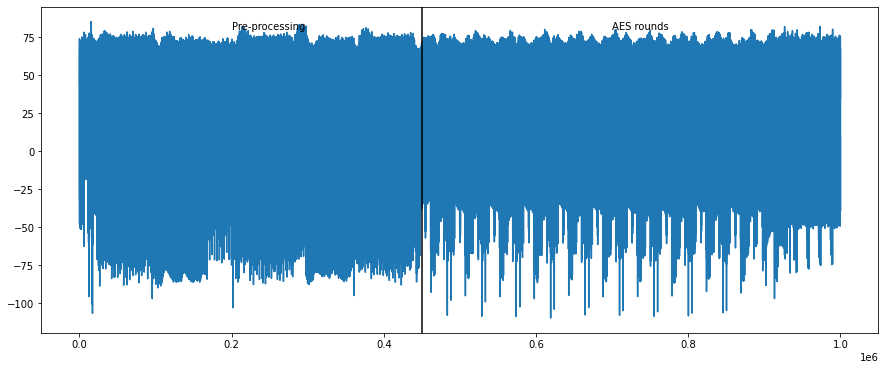

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.plot(trace_mean)
plt.axvline(450000, color="black")
plt.text(200000, 80, "Pre-processing")
plt.text(700000, 80, "AES rounds")

What is also noticeable is that similar patterns may be found inside the operations `aes_loadKey`, `aes_enc_init`, and `aes_enc`. In particular, three `Gtab` and two `Sbox` pre-computations are made of 256-for-loops, that may be easily distinguishable from the remaining of the trace. On the contrary, the other elementary operations done here only contain much shorter loops, resulting in shorter patterns.

Text(700000, 100, 'AES rounds')

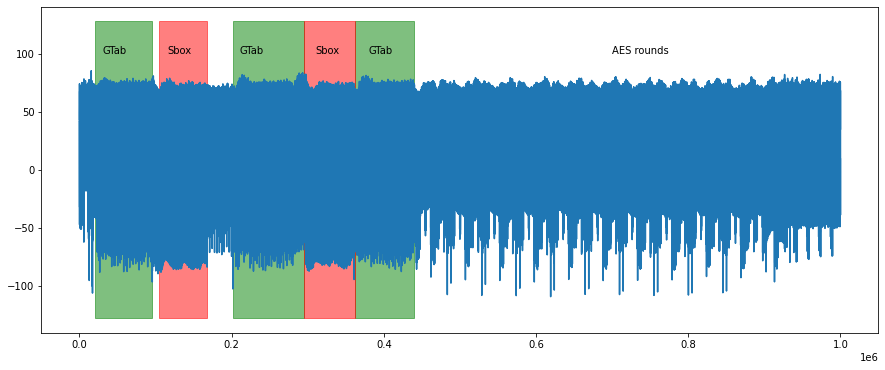

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.plot(trace_mean)

plt.fill_betweenx((-128,128), (20000, 20000), (95000, 95000), alpha=0.5, color="green")
plt.text(30000, 100, "GTab")
plt.fill_betweenx((-128,128), (202000, 202000), (295000, 295000), alpha=0.5, color="green")
plt.text(210000, 100, "GTab")
plt.fill_betweenx((-128,128), (362000, 362000), (440000, 440000), alpha=0.5, color="green")
plt.text(380000, 100, "GTab")

plt.fill_betweenx((-128,128), (105000, 105000), (167000, 167000), alpha=0.5, color="red")
plt.text(115000, 100, "Sbox")
plt.fill_betweenx((-128,128), (295000, 295000), (362000, 362000), alpha=0.5, color="red")
plt.text(310000, 100, "Sbox")

plt.text(700000, 100, "AES rounds")

### Which leakage choosing for $r_m$?

We have seen that some informative leakage about $r_m$ may occur in both `compute_GTab` and `Compute_Affine_sboxMasked`. However, the time windows corresponding to the two operations are quite large, so we may want to restrict to only one chunk, without necessarily losing too much information about the multiplicative mask. Let us have a look at the assembly code, in order to find which operation may carry the most relevant leakage.

#### `Load_random` (l. 398 - 450)
This function loads all the masks, in particular $r_{in}, r_{out}$ and $r_m$ from the context and is called just before the function `Compute_GTab` (see below).
The instructions are mainly loadings and storings, but the function does not contain any loop. The leakage of any mask is therefore expected to occur very punctually, and to be harder to localize, since there is no distinguishable pattern.

#### `Compute_GTab` (l. 208 - 277)
The computation table uses the logarithmic table. The value $\log r_m$ is stored in the register `r7` that is then iteratively added to the current value $\log x$ for $x \in \{1, ..., 255\}$. However, it does not manipulate the other required masks $r_{in}$ and $r_{out}$.

#### `Compute_Affine_sboxMasked` (l. 452 - 510)
The pre-computation of the Sbox indirectly uses $r_m$, through the call to the `GTab` look-up table for each value of $x \in \{0, ..., 255\}$. While maybe carrying as much information as the GTab computation, this operation may induce more complex leakage. 

In our attacks, we propose to restrict our focus on the leakage of the `Compute_GTab` operation and the `Load_random` just before. This corresponds to a $5,000$ times samples window: $[205000:210000]$ covering the end of the `Load_random` function and the beginning of the `Compute_GTab` function, as depicted hereafter.

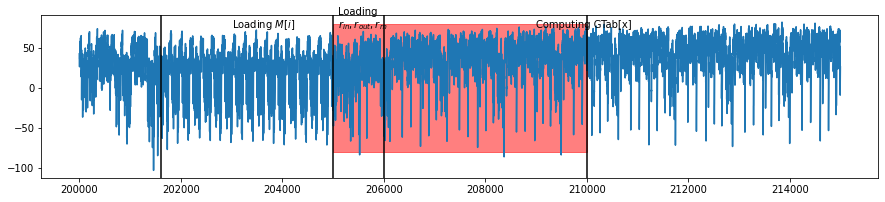

In [ ]:
fig=plt.figure(figsize=(15, 3))
left, right = 200000, 215000
plt.plot(range(left, right), trace_mean[left:right])

plt.axvline(201600, color="black")
plt.text(203000, 75, "Loading $M[i]$")

plt.axvline(205000, color="black")
plt.text(205100, 75, "Loading\n$r_{in}, r_{out}, r_m$")
plt.axvline(206000, color="black")

plt.axvline(210000, color="black")
plt.text(209000, 75, "Computing GTab[x]")

plt.fill_betweenx((-80,80), (205000, 205000), (210000, 210000), alpha=0.5, color="red")

## 2. Localization of the remaining PoIs

We now consider finding the remaining PoIs. The latter one must correspond to the leakage of the permutation indices, in order to possibly anihilate the effect of the shuffling counter-measure, and to the leakage of the masked variable. The latter one necessarily leaks during the AES rounds. Therefore, we propose to deeper study the code of the function `aes_enc`, in order to better localize those PoIs.

### 2.1. Focus on the AES rounds

We first restrict our visualization on the range $[400,000;1M]$. We still find the 10 similar patterns, confirming the presence of the AES rounds.

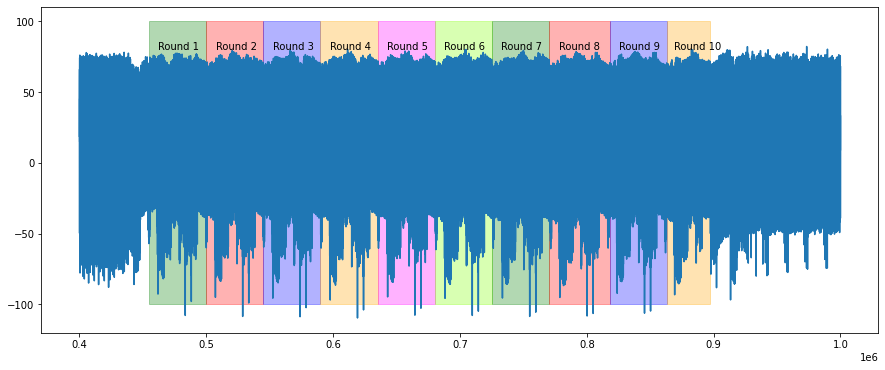

In [ ]:
fig=plt.figure(figsize=(15, 6))

bounds = [454500, 500000, 545000, 590000, 635000, 680000, 725000, 770000, 818000, 863000, 897000]
colors = ["green", "red", "blue", "orange", "magenta", "chartreuse"]

for i in range(0, len(bounds)-1):
    plt.fill_betweenx((-100, 100), (bounds[i], bounds[i]), (bounds[i+1], bounds[i+1]), alpha=0.3, color=colors[i%len(colors)])
    plt.text((bounds[i]*5 + bounds[i+1])/6, 80, "Round {}".format(i+1))

plt.plot(np.arange(400000, 1e6), trace_mean[400000:])

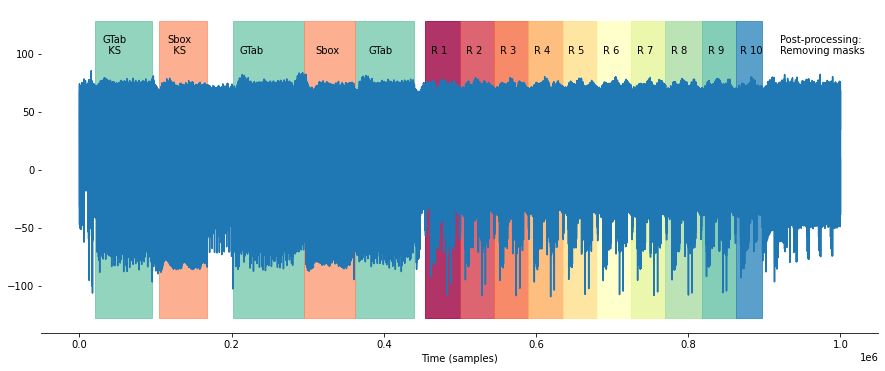

In [ ]:
fig=plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
bmap = brewer2mpl.get_map('Spectral', 'diverging', 11)
colors = bmap.mpl_colors

bounds = [454500, 500000, 545000, 590000, 635000, 680000, 725000, 770000, 818000, 863000, 897000]

for i in range(0, len(bounds)-1):
    ax.fill_betweenx((-128, 128), (bounds[i], bounds[i]), (bounds[i+1], bounds[i+1]), alpha=0.8, color=colors[i%len(colors)])
    ax.text((bounds[i]*5 + bounds[i+1])/6, 100, "R {}".format(i+1))

bmap = brewer2mpl.get_map('Set2', 'qualitative', 7)
colors = bmap.mpl_colors

ax.fill_betweenx((-128,128), (20000, 20000), (95000, 95000), alpha=0.7, color=colors[0])
ax.text(30000, 100, "GTab\n  KS")
ax.fill_betweenx((-128,128), (202000, 202000), (295000, 295000), alpha=0.7, color=colors[0])
ax.text(210000, 100, "GTab")
ax.fill_betweenx((-128,128), (362000, 362000), (440000, 440000), alpha=0.7, color=colors[0])
ax.text(380000, 100, "GTab")

ax.fill_betweenx((-128,128), (105000, 105000), (167000, 167000), alpha=0.7, color=colors[1])
ax.text(115000, 100, "Sbox\n  KS")
ax.fill_betweenx((-128,128), (295000, 295000), (362000, 362000), alpha=0.7, color=colors[1])
ax.text(310000, 100, "Sbox")

ax.text(920000, 100, "Post-processing:\nRemoving masks")

ax.plot(trace_mean)

ax.set_xlabel("Time (samples)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### 2.2. Focus on the first AES round
We now focus on the first AES round, in order to identify the underlying operations. We distinguish 8 different zones, each containing similar patterns inside. Below, we even delimit each zone.

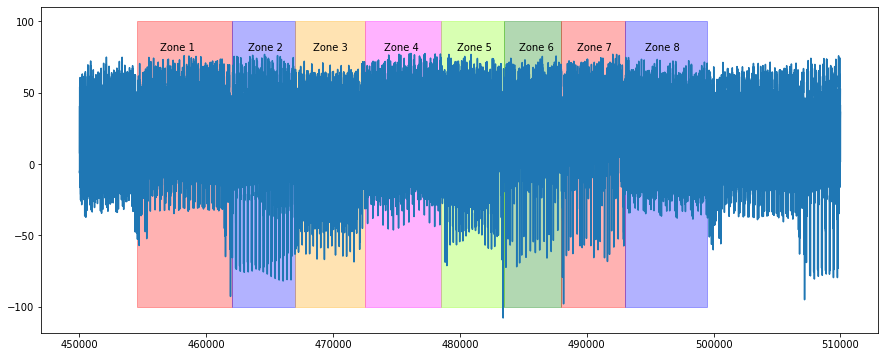

In [ ]:
left, right = 450000, 510000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])

bounds = [450000, 454500, 462000, 467000, 472500, 478500, 483500, 488000, 493000, 499500, 510000]
colors = ["green", "red", "blue", "orange", "magenta", "chartreuse"]

for i in range(1, len(bounds)-2):
    plt.fill_betweenx((-100, 100), (bounds[i], bounds[i]), (bounds[i+1], bounds[i+1]), alpha=0.3, color=colors[i%len(colors)])
    plt.text((bounds[i]*3 + bounds[i+1])/4, 80, "Zone {}".format(i))
 

### 2.3. Focus on each zone
Hereafter, we try to identify each zone to a piece of assembly code, by identifying the elementary patterns inside them. Then, we will compare the occurence of those patterns with the assembly code, in order to match them.

We begin by the Zone 1, plotted below. We observe **16 identical patterns**, delimited by the black vertical lines.

Text(0.5, 1.0, 'Zone 1')

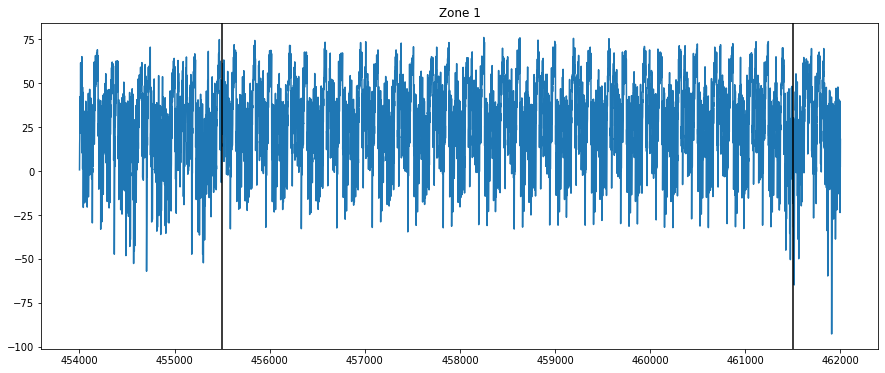

In [ ]:
left, right = 454000, 462000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(455500, color="black")
plt.axvline(461500, color="black")
plt.title("Zone 1")

We continue with the Zone 2 plotted below, on which we also recognize **16 similar patterns** although the latter ones are different from the ones observed in the Zone 1.

Text(0.5, 1.0, 'Zone 2')

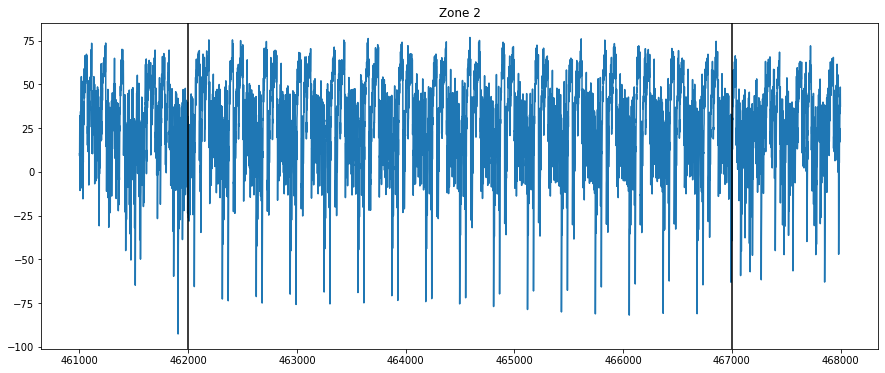

In [ ]:
left, right = 461000, 468000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(462000, color="black")
plt.axvline(467000, color="black")
plt.title("Zone 2")

Likewise, the Zone 3 plotted below depicts **16 similar patterns**, here again seemingly different from the previous ones.

Text(0.5, 1.0, 'Zone 3')

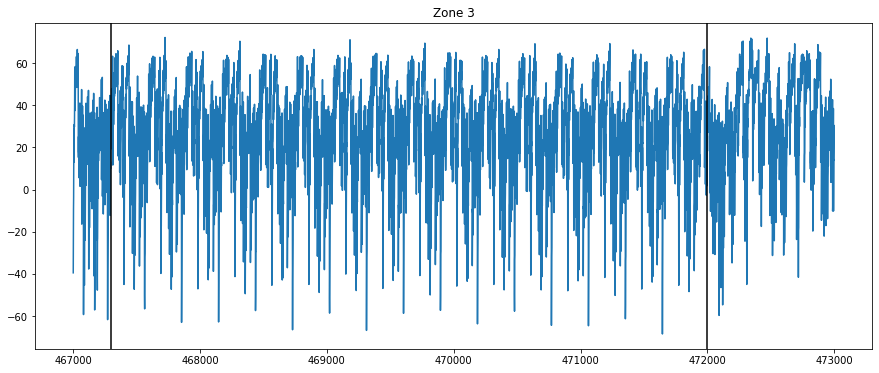

In [ ]:
left, right = 467000, 473000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(467300, color="black")
plt.axvline(472000, color="black")
plt.title("Zone 3")

Same thing here with the Zone 4 depicted below, with **16 similar patterns**.

Text(0.5, 1.0, 'Zone 4')

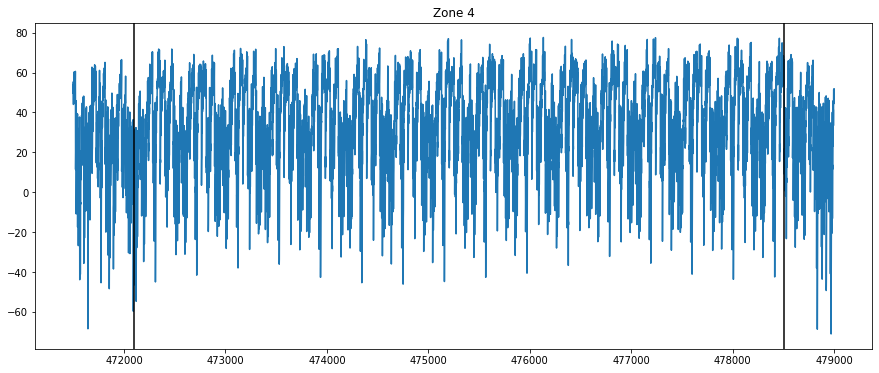

In [ ]:
left, right = 471500, 479000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(472100, color="black")
plt.axvline(478500, color="black")
plt.title("Zone 4")

Idem with the Zone 5 plotted below, with **16 similar patterns**.

Text(0.5, 1.0, 'Zone 5')

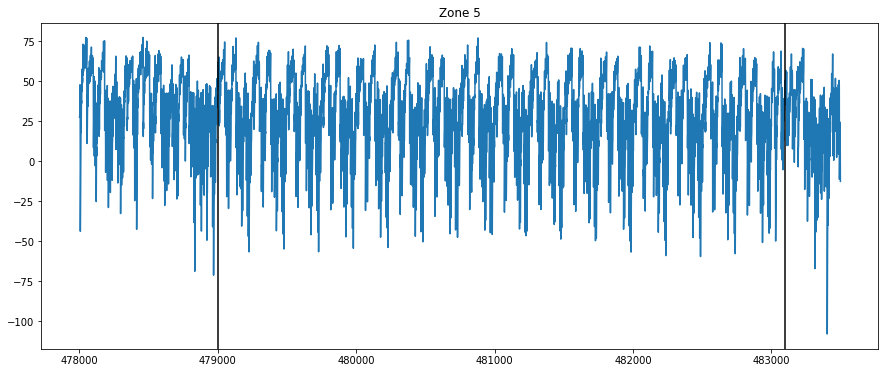

In [ ]:
left, right = 478000, 483500
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(479000, color="black")
plt.axvline(483100, color="black")
plt.title("Zone 5")

Now interestingly, we have below **4 different patterns** in the Zone 6, each made of **4 sub-patterns**.

Text(0.5, 1.0, 'Zone 6')

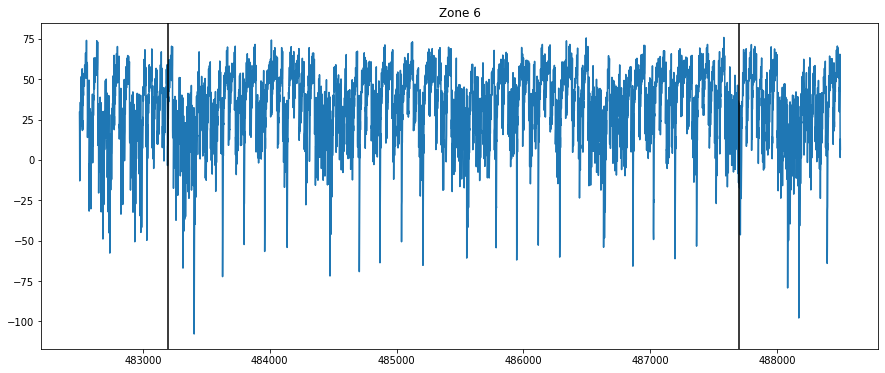

In [ ]:
left, right = 482500, 488500 
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(483200, color="black")
plt.axvline(487700, color="black")
plt.title("Zone 6")

Likewise, the same pattern can be observed on the Zone 7, namely **4 patterns each made of 4 sub-patterns**.

Text(0.5, 1.0, 'Zone 7')

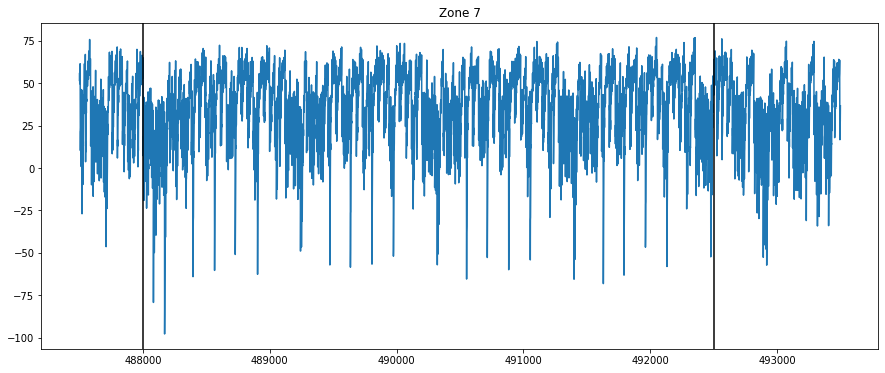

In [ ]:
left, right = 487500, 493500
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(488000, color="black")
plt.axvline(492500, color="black")
plt.title("Zone 7")

Finally, we recognize in the Zone 8 **32 blocs**, delimited by the black vertical lines below.

Text(0.5, 1.0, 'Zone 8')

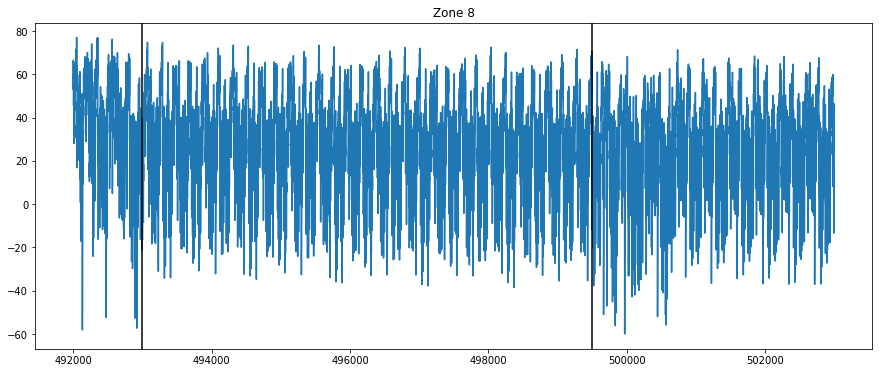

In [ ]:
left, right = 492000, 503000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(493000, color="black")
plt.axvline(499500, color="black")
plt.title("Zone 8")

Now let us compare the observed patterns in the different Zones with the assembly code provided to the attacker/evaluator.
We recognize several loops that can be explicitly unrolled depending on the compiling options:

* `SubBytes` (Zone 1):
    * Loop of 4 to substitute the additive mask with $r_{in}$, word-wise
    * Loop of 16 to appply the SBox on each byte
    * Loop of 4 to remove the additive mask $r_{out}$, applied word-wise
* `ShiftRows` (Zones 2-5):
    * Loop of 16 to apply ShiftRows on `maskedState` and storing it on a temporary table
    * Loop of 16 to move the result to `maskedState`
    * Loop of 16 to apply ShiftRows on `stateM` and storing it on a temporary table
    * Loop of 16 to move the result to `stateM`
* `MixColumns` (Zones 6-7):
    * Loop of 4 to apply the operation column-wise, i.e. 4 sub-patterns for `stateM`
    * Idem on `maskedState`
* `AddRoundKey` (Zone 8):
    * Loop of 16, containing 2 similar sub-patterns, first ARK on `stateM`, then on `maskedState`, hence the 32 similar patterns.

The particular status of the `MixColumns` operation provides an easy discrepancy compared to the other operations. Therefore, we deduce that the Zones 6 and 7 correspond to the two `MixColumns`. We then deduce the remaining operations previously identified: the first Zone corresponds to `SubBytes`, and that the first `AddRoundKey` is done just before. We can then try to identify it on the trace. Below, we recognize here the 32 similar patterns, which confirms that the trace chunk corresponds to the first `AddRoundKey`, as expected.

Text(0.5, 1.0, 'AddRoundKey, Round 0')

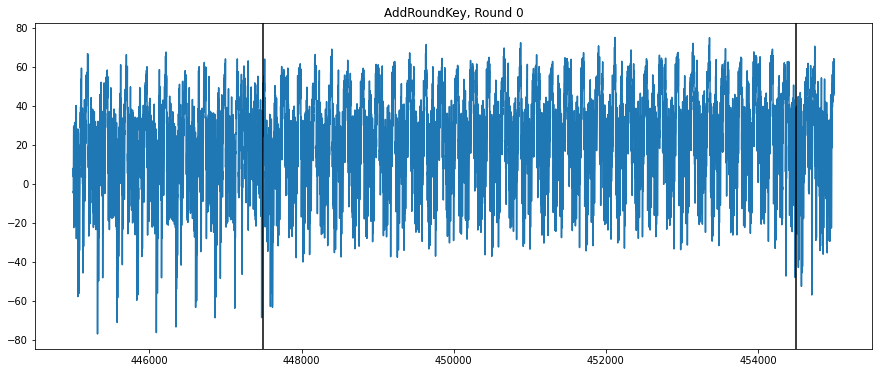

In [ ]:
left, right = 445000, 455000
fig=plt.figure(figsize=(15, 6))
plt.plot(np.arange(left, right), trace_mean[left:right])
plt.axvline(447500, color="black")
plt.axvline(454500, color="black")
plt.title("AddRoundKey, Round 0")

### 2.4. Overall target window

In our attack, we restrict our traces to the following target window: $[455000:465000]$. Indeed, we have seen that this window widely covers the whole `SubBytes` operation, along with the preliminary swap of mask between `stateM` and $r_{in}$ and the posterior swap between $r_{out}$ and `stateM`.

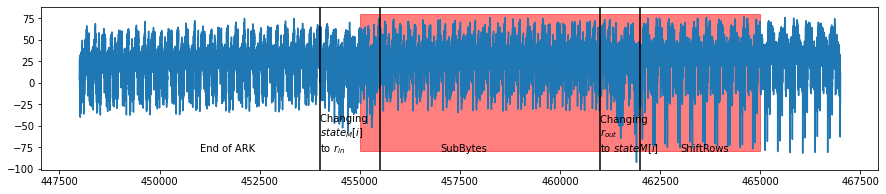

In [ ]:
fig=plt.figure(figsize=(15, 3))
left, right = 448000, 467000
plt.plot(range(left, right), trace_mean[left:right])


plt.axvline(454000, color="black")
plt.axvline(455500, color="black")
plt.axvline(461000, color="black")
plt.axvline(462000, color="black")


plt.text(451000, -80, "End of ARK")
plt.text(454000, -80, "Changing \n$state_M[i]$ \nto $r_{in}$")
plt.text(457000, -80, "SubBytes")
plt.text(461000, -80, "Changing \n$r_{out}$ \nto $stateM[i]$")
plt.text(463000, -80, "ShiftRows")

plt.fill_betweenx((-80,80), (455000, 455000), (465000, 465000), alpha=0.5, color="red")

### 2.5. `permIndices` localization

We have seen that our target window covers the whole SubBytes operation, along with some potential leakages of relevant masks such as $r_{in}$ or $r_{out}$. But we have not verified yet that our target window does cover some leakages about the permutation indices. Although not mandatory, exploiting such leakages would help the adversary to mitigate the effect of random shuffling. Hopefully, such leakages are indeed present inside our target window. To justify this, we recall hereafter a chunk of assembly code inside the loop of the `SubBytes` operation. It clearly shows that the `permIndices` table leaks inside the target window.

```
	 ldrb r0, [r5], #1				// r0 = permIndices[i]
	 ldrb r4, [r3, r0]				// r4 = State[permIndices[i]]
	 ldrb r6, [r10, r0]			   // r6 = State2[permIndices[i]]
	 eor  r4, r6 					 // r4 = State[permIndices[i]] ^ State2[permIndices[i]]
	 ldrb r4, [r8, r4]				// r4 = sboxMasked[State[permIndices[i]] ^ State2[permIndices[i]]]
	 eor  r4, r6 					 // r4 = sboxMasked[State[permIndices[i]]
	 strb r4, [r3, r0]				// store the result r4 in State[permIndices[i]]
```

# **Conclusion**

Altogether, our proposed target window covers all the leakages necessary to succeed an attack. We insist yet on the fact that our target window is not unique, and other windows could be as relevant as ours, if not more.